# Detekcja obiektów

**Kolejnym zagadnieniem istotnym w analizie obrazów, jest detekcja obiektów. Może ona być pomocna w szacowaniu ilości pewnego typu obiektów na obrazie czy też wyznaczania ich dokładnego położenia.  Tutaj pokażemy kilka typowych przekształceń opierających się na wyszukiwaniu określonych kształtów.**

In [1]:
import cv2
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt

### Detekcja linii 

Po załadowaniu niezbędnych bibliotek, wczytano obraz na dwa znane Ci już sposoby: za pomocą *Image.open()* (po to, by go wyświetlić w poradniku) oraz za pomocą *cv2.imread()* – ten będzie wejściem do kolejnych funkcji.

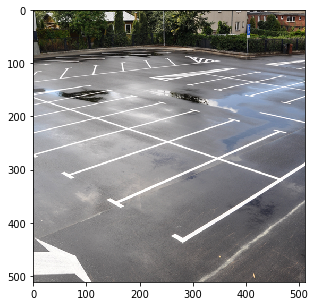

In [2]:
img = Image.open('../obrazy_testowe/parking_512x512.png')
imgColArray = cv2.imread('../obrazy_testowe/parking_512x512.png')
imgGrey = img.convert('L')
imgArray = np.asarray(imgGrey)
plt.figure(1, figsize = (5, 5))
plt.imshow(img)
plt.show()

Podobnie jak przy operacjach morfologicznych, tutaj też pracujemy na obrazach binarnych. Tym razem dobraślimy ręcznie próg odcięcia, by lepiej wyodrębnienić interesujące nas obiekty - linie. Na parkingu są one białe, dlatego ustalony próg jest dość wysoki (wartość 200).

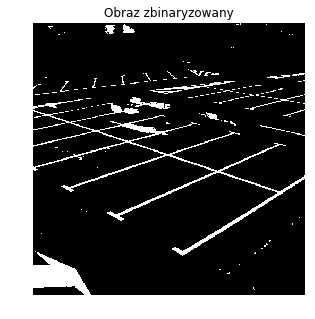

In [3]:
ret, imgBin = cv2.threshold(imgArray, 200, 255, cv2.THRESH_BINARY)

plt.figure(1, figsize = (5, 5))
plt.imshow(imgBin, cmap = 'gray')
plt.title('Obraz zbinaryzowany')
plt.axis('off')
plt.show()

Detekcji linii dokonaliśmy za pomocą funkcji *cv2.HoughLinesP()* (możesz także użyć mniej zoptymalizowanej funkcji *cv2.HoughLines()*, ale obliczenia zajmują zdecydowanie więcej czasu). W niej należy zdefiniować:
* obraz wejściowy (binarny),
* dwa parametry opisujące linię w układzie współrzędnych biegunowych:
    - rho: rozdzielczość podana w pikselach (u nas równa 1),
    - theta: rozdzielczość podana w radianach – u nas równa 1 stopień, czyli *pi/180*,
* minimalna liczba przecięć "wyszukujących" linię – jego zmiana znacząco wpływa na wynik, 
* minimalna długość poszukiwanej linii (podana w pikselach),
* maksymalna przerwa w obrębie jednej linii (także w pikselach).

Znalezione linie wyrysowaliśmy za pomocą funkcji *cv2.line()*, na podstawie współrzędnych linii odnalezionych przez detektor. Funkcja *np.size()* z&nbsp;parametrem&nbsp;*0*&nbsp;zlicza wiersze macierzy, które u nas są liczbą znalezionych linii.

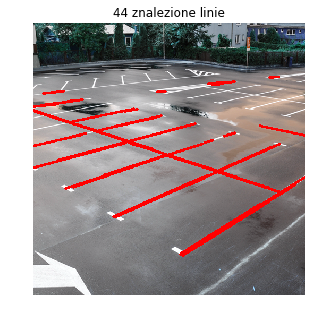

In [4]:
minLineLength = 10
maxLineGap = 10
lines = cv2.HoughLinesP(imgBin, 1, np.pi/180, 150, minLineLength, maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(imgColArray, (x1,y1), (x2,y2), (255,0,0), 4)

countLines = np.size(lines, 0)        
plt.figure(1, figsize = (5, 5))
plt.imshow(imgColArray)
plt.title(str(countLines) + ' znalezione linie')
plt.axis('off')
plt.show()

### Detekcja obiektów niejednorodnych

Innym przykładem zastosowania metod detekcji, może być poszukiwanie obiektów, które nie posiadają zdefiniowanego kształtu, tak jak poniższe komórki i ich jądra komórkowe. 

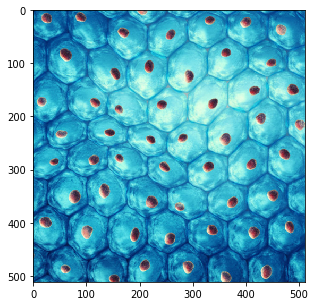

In [5]:
img = Image.open('../obrazy_testowe/cells_512x512.png')
imgGrayArray = cv2.imread('../obrazy_testowe/cells_512x512.png', cv2.IMREAD_GRAYSCALE)
plt.figure(1, figsize = (5, 5))
plt.imshow(img)
plt.show()

Tym razem użyliśmy funkcji *cv2.SimpleBlobDetector()*, dla której najpierw zdefiniowaliśmy takie parametry jak: minimalna i maksymalna szukana powierzchnia obiektów, współczynniki okrągłości, stałości czy wydłużenia obiektów, a także próg odcięcia. Następnie dokonano przeszukania obrazu (*detector.detect()*), z&nbsp;uwzględnieniem zdefiniowanych parametrów. Znalezione obiekty zaznaczono okręgami za pomocą funkcji *cv2.drawKeypoints()*. Przyjmuje ona:
* obraz wejściowy, 
* macierz z punktami, w których znajdują się znalezione obiekty, 
* pustą macierz na obraz wynikowy, 
* opis koloru zaznaczenia w przestrzeni RGB (u nas będzie to czerwony),
* dalsze flagi, których dokładne opisy znajdziesz w dokumentacji.

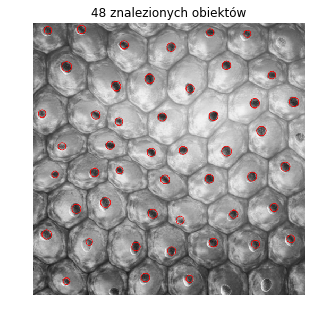

In [6]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.filterByColor = False
params.filterByCircularity = True
params.minThreshold = 0
params.maxThreshold = 255
params.minArea = 100
params.maxArea = 300
params.minCircularity = 0.52
params.minConvexity = 0.1
params.minInertiaRatio = 0.1

detector = cv2.SimpleBlobDetector_create(params)
objects = detector.detect(imgGrayArray)
imgWithObjects = cv2.drawKeypoints(imgGrayArray, objects, np.array([]), (255, 0, 0), 
                                   cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

countObj = len(objects)
plt.figure(1, figsize = (5, 5))
plt.imshow(imgWithObjects)
plt.title(str(countObj) + ' znalezionych obiektów')
plt.axis('off')
plt.show()

Zauważ, że można także filtrować obiekty uwzględniając ich kolor – uda Ci się policzyć jądra komórkowe w ten sposób?

### Detekcja okręgów

Często może również istnieć potrzeba odnalezienia okręgów na obrazie – tak jak na zdjęciu zawierającym znaki drogowe. Po wczytaniu obrazu dokonano binaryzacji, w celu lepszego wyodrębnienia okręgów. 

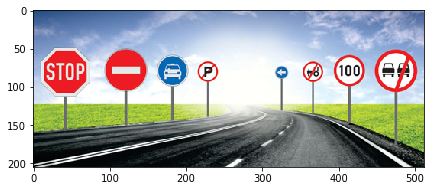

In [7]:
img = Image.open('../obrazy_testowe/signs_512x205.png')
imgGrayArray = cv2.imread('../obrazy_testowe/signs_512x205.png', cv2.IMREAD_GRAYSCALE)
ret, imgBin = cv2.threshold(imgGrayArray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(1, figsize = (7, 7))
plt.imshow(img)
plt.show()

Do detekcji użyto funkcji *cv2.HoughCircles()*, w niej definiujemy:
* obraz wejściowy (zbinaryzowany),
* metodę detekcji (obecnie zaimplementowana jest tylko *cv2.HOUGH_GRADIENT*),
* współczynnik rozdzielczości akumulatora, który jest odwrotny do rozdzielczości obrazu – przy wartości 1 oba będą mieć ten sam rozmiar,
* minimalną odległość pomiędzy szukanymi okręgami (w pikselach), 
* dwa parametry określające progi odcięcia do metody *cv2.HOUGH_GRADIENT*,
* minimalną i maksymalną wartość promienia wyszukiwanych okręgów (podana w pikselch).

Okręgi wyrysowano następnie za pomocą funkcji *cv2.circle()*, podając jako parametry współrzędne okręgów, a także ich kolor i grubość.

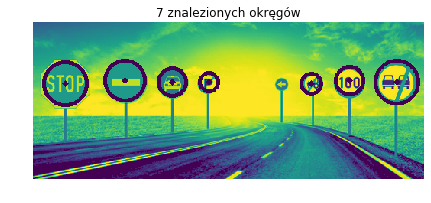

In [8]:
circles = cv2.HoughCircles(imgBin, cv2.HOUGH_GRADIENT, 1, 40, param1=50, param2=20, minRadius=5, maxRadius=30)

circles = np.around(circles)
for i in circles[0,:]:
    # wyrysowanie okręgu zewnętrznego
    cv2.circle(imgGrayArray, (i[0],i[1]), i[2], (0,0,0), 3)
    # wyrysowanie środka okręgu
    cv2.circle(imgGrayArray, (i[0],i[1]), 2, (0,0,0), 4)

countCirc = np.size(circles[0], 0)
plt.figure(1, figsize = (7, 7))
plt.imshow(imgGrayArray)
plt.title(str(countCirc) + ' znalezionych okręgów')
plt.axis('off')
plt.show()

Przykładowa macierz znalezionych okręgów może wyglądać następująco. Każdy wiersz zawiera współrzędne (*x, y*) środka okręgu oraz jego promień.

In [9]:
circles

array([[[476.,  78.,  28.],
        [ 42.,  80.,  28.],
        [414.,  76.,  18.],
        [182.,  78.,  18.],
        [120.,  76.,  26.],
        [364.,  80.,  13.],
        [230.,  78.,  12.]]], dtype=float32)

Przy próbie dostosowania parametrów poszczególnych detektorów można zaobserwować, iż są one bardzo wrażliwe na ich zmianę. Często zatem wyniki detekcji nie są w pełni zadowalające – brakuje niektórych obiektów lub jest ich za dużo. Powoduje to konieczność poświęcenia większej uwagi tej części detekcji.